In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import path
from collections import defaultdict

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

In [2]:
# READ DATA: Blade landings 

blade_landings= pd.read_csv('blade_landing_helihoist_sbitroot.txt')

# make epoch index of dataframe and convert epoch into readable dates
blade_landings.epoch_land= blade_landings.epoch_land.apply(lambda x: pd.to_datetime(x, unit= 's', utc=True))

# convert blade landings of turbine 8 into readable dates
blade_landing1= pd.to_datetime(1.571127e+09	, unit='s', utc=True)
blade_landing2= pd.to_datetime(1.571154e+09, unit='s', utc=True)
blade_landing3= pd.to_datetime(1.571188e+09, unit='s', utc=True)

landings = (blade_landing1, blade_landing2, blade_landing3)

In [3]:
# Determine blade landing period

landing_delta = pd.to_timedelta(5, unit='m')

blade1_start = blade_landing1 - landing_delta
blade1_end = blade_landing1 + landing_delta

blade2_start = blade_landing2 - landing_delta
blade2_end = blade_landing2 + landing_delta

blade3_start = blade_landing3 - landing_delta
blade3_end = blade_landing3 + landing_delta

In [4]:
# Read csv files of GPS Data: turbine 8

# sbitroot
gps_sbitroot_tb8= pd.read_csv('turbine-08_sbitroot_tom_gps.csv')
gps_sbitroot_tb8.epoch= pd.to_datetime(gps_sbitroot_tb8.epoch, unit= 's', utc=True)
gps_sbitroot_tb8.set_index('epoch', inplace=True)

# sbittip
gps_sbittip_tb8= pd.read_csv('turbine-08_sbittip_tom_gps.csv')
gps_sbittip_tb8.epoch= pd.to_datetime(gps_sbittip_tb8.epoch, unit= 's', utc=True)
gps_sbittip_tb8.set_index('epoch', inplace=True)

# helihoist
gps_helih_tb8= pd.read_csv('turbine-08_helihoist-1_tom_gps.csv')
gps_helih_tb8.epoch= pd.to_datetime(gps_helih_tb8.epoch, unit= 's', utc=True)
gps_helih_tb8.set_index('epoch', inplace=True)

In [5]:
# Find blade installation period in data

hub_height = 90 # hub height = 90m

# smoothing the time series: cut the outliers and find the 20min mean value
hh, sr, st = (gps_helih_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbitroot_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbittip_tb8.altitude.resample('1s').mean().rolling('20min').mean())

hh_sbi = hh[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
sr_sbi = sr[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
st_sbi = st[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]

# determine start and end period of single blade installations
inst_period = sr_sbi[sr_sbi.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
inst_period.insert(0, hh_sbi.index[0])
inst_period.insert(len(inst_period), hh_sbi.index[-1])
sbi_indices = list()

for i in range(len(inst_period) - 1):
    sbi_indices.append((inst_period[i], hh_sbi[inst_period[i]:inst_period[i+1]].index[-2]))

<IPython.core.display.Javascript object>


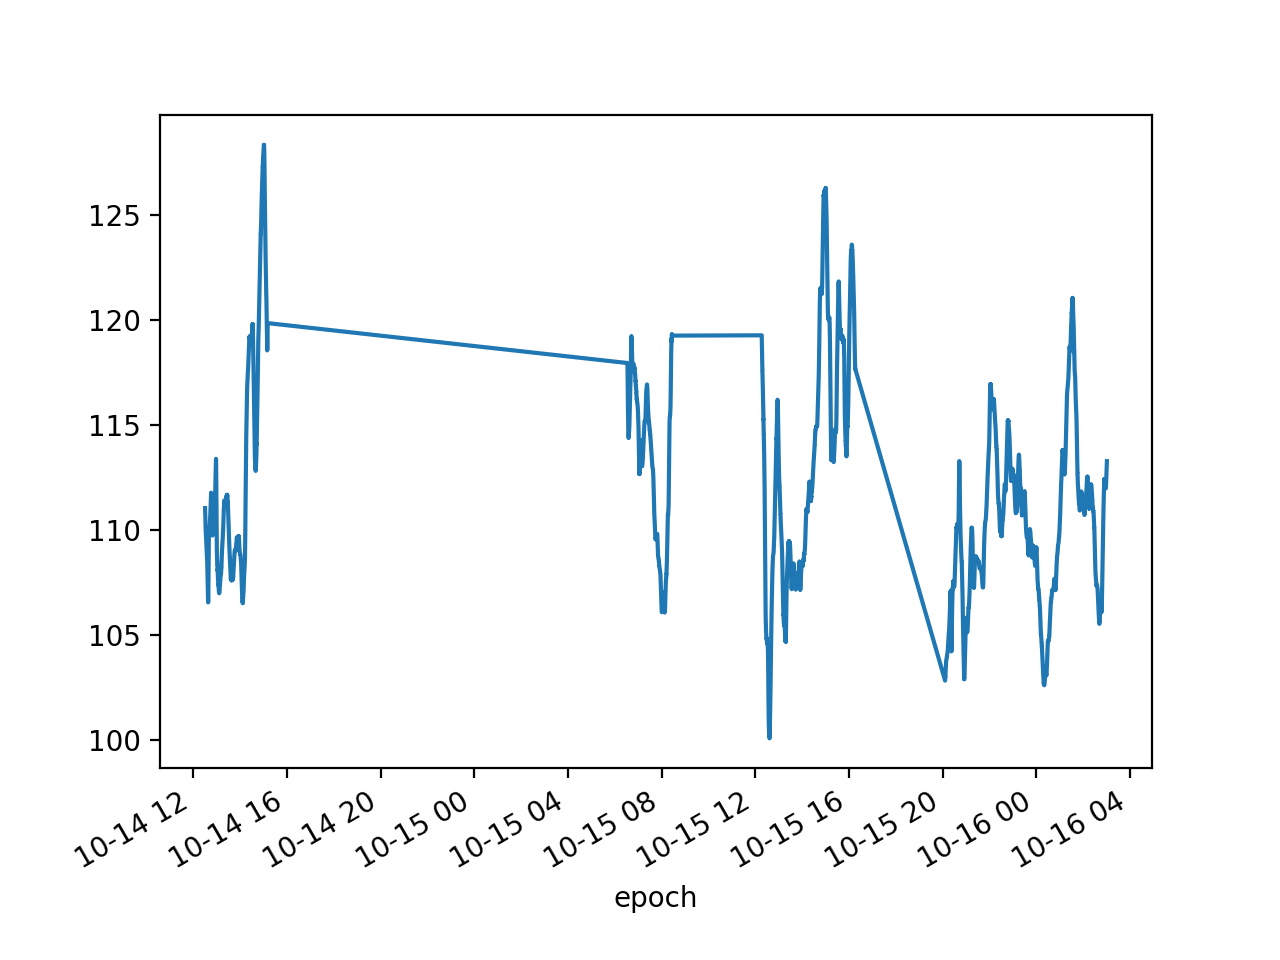

<AxesSubplot:xlabel='epoch'>

In [6]:
plt.figure()
hh_sbi.plot()

In [7]:
inst_period

[Timestamp('2019-10-14 12:30:18+0000', tz='UTC'),
 Timestamp('2019-10-15 06:32:25+0000', tz='UTC'),
 Timestamp('2019-10-15 12:16:23+0000', tz='UTC'),
 Timestamp('2019-10-15 20:06:10+0000', tz='UTC'),
 Timestamp('2019-10-16 03:00:46+0000', tz='UTC')]

In [8]:
#start= pd.DataFrame(start)
#end= pd.DataFrame(end)
#start_end = pd.concat([start, end], axis=1)
#start_end.columns = ['start', 'end']

In [9]:
hh= pd.DataFrame(hh)
sr= pd.DataFrame(sr)
st= pd.DataFrame(st)

<IPython.core.display.Javascript object>


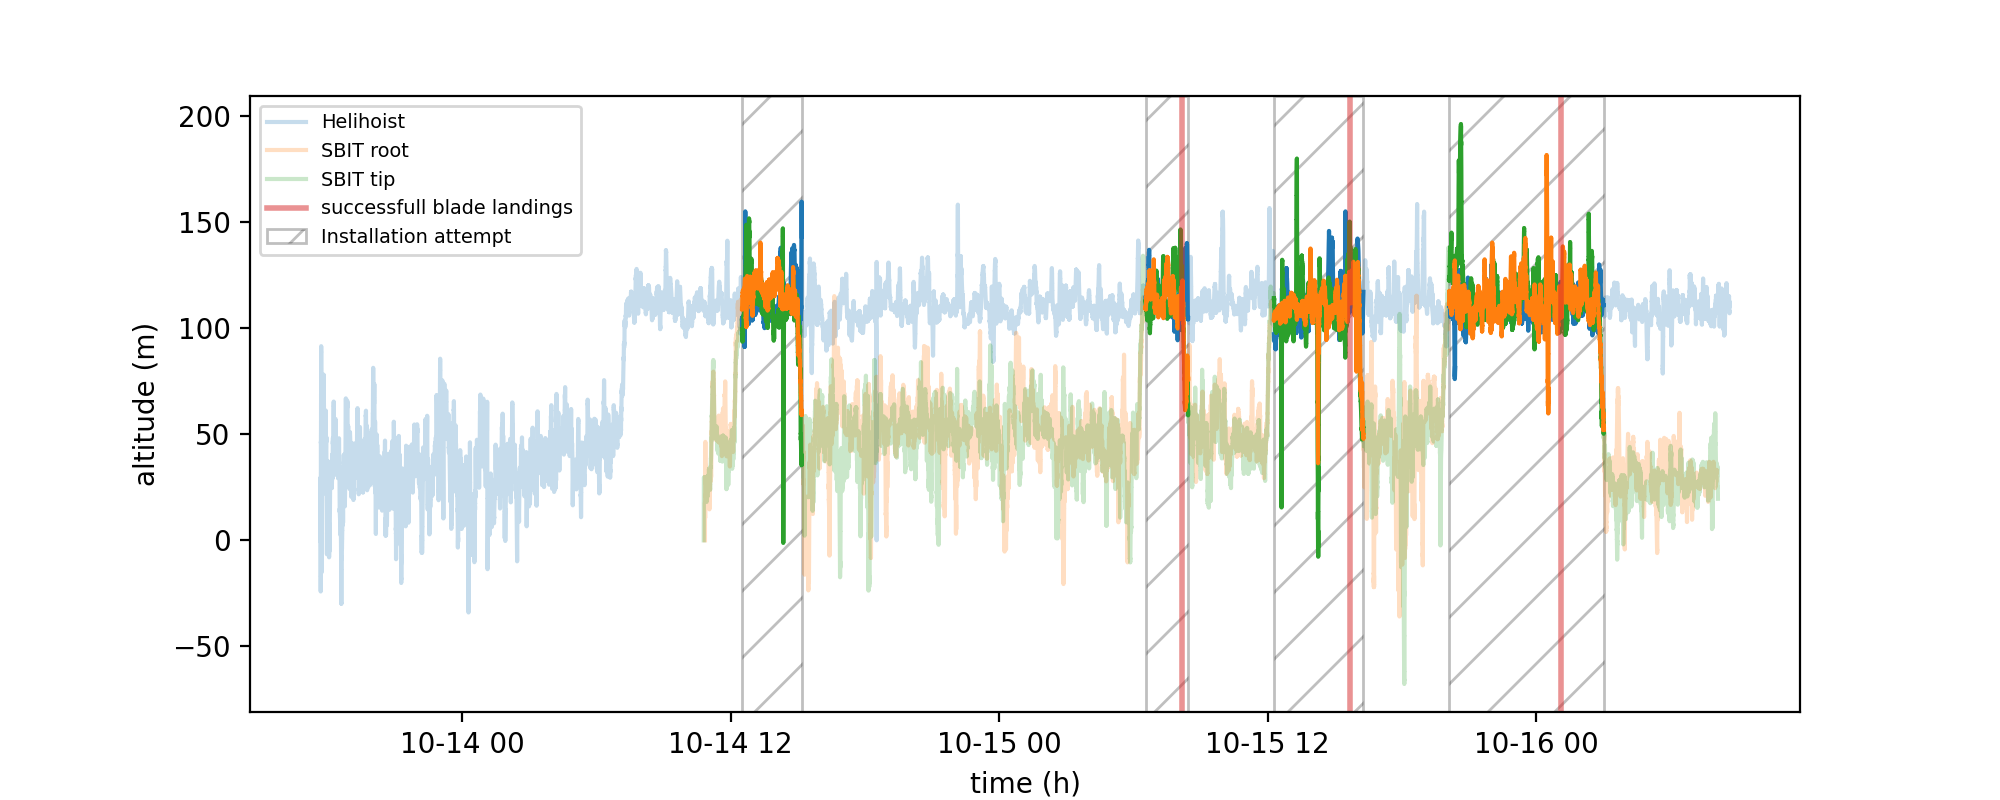

In [10]:
plt.figure(figsize=(10,4))
plt.plot(gps_helih_tb8.altitude, alpha=0.25, label='Helihoist', color='tab:blue')
plt.plot(gps_sbitroot_tb8.altitude, alpha=0.25, label='SBIT root', color='tab:orange')
plt.plot(gps_sbittip_tb8.altitude, alpha=0.25, label='SBIT tip', color='tab:green')

# [0] [0]= start value [0][1] end value
#[sbi_indices[0][0]:]

for start, end in sbi_indices:
    gps_helih_tb8[start:end]
    plt.plot(gps_helih_tb8[start:end].altitude, color='tab:blue')
    plt.plot(gps_sbittip_tb8[start:end].altitude, color='tab:green')
    plt.plot(gps_sbitroot_tb8[start:end].altitude, color='tab:orange') 
    
    
plt.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation attempt')   
plt.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
plt.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   

plt.axvline(x=blade_landing1, alpha=0.5, color='tab:red', linewidth=2, label='successfull blade landings')
plt.axvline(x=blade_landing2, alpha=0.5, color='tab:red', linewidth=2)
plt.axvline(x=blade_landing3, alpha=0.5, color='tab:red', linewidth=2)

plt.ylabel('altitude (m)')
plt.xlabel('time (h)')
plt.legend(loc='upper left', fontsize= 'x-small')
plt.savefig('blade_landings', dpi=300)

In [11]:
# zwei bedingungen um installationsdaten zu filtern: Höhe und Beschleunigung, Höhe, um den Start zu identifizieren
# Beschleunigung um Impact events auszuschließen

In [12]:
# concatenate csv data of helihoist 

path_hh = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/Helihoist'
hh_files = glob(path_hh + "/*.csv")

hh_data_tb8 = []

for filename in hh_files:
    hh_df = pd.read_csv(filename, index_col=None, header=0)
    hh_data_tb8.append(hh_df)

hh_frame = pd.concat(hh_data_tb8, axis=0, ignore_index=True)

hh_frame.epoch= pd.to_datetime(hh_frame.epoch, unit= 's', utc=True)
hh_frame.set_index('epoch', inplace=True)
hh_frame = hh_frame.sort_index()

# concatenate csv data of sbitroot

path_sbitroot = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbitroot'
sbitroot_files = glob(path_sbitroot + "/*.csv")

sbitroot_data_tb8 = []

for filename in sbitroot_files:
    sbitroot_df = pd.read_csv(filename, index_col=None, header=0)
    sbitroot_data_tb8.append(sbitroot_df)

sbitroot_frame = pd.concat(sbitroot_data_tb8, axis=0, ignore_index=True)

sbitroot_frame.epoch= pd.to_datetime(sbitroot_frame.epoch, unit= 's', utc=True)
sbitroot_frame.set_index('epoch', inplace=True)
sbitroot_frame = sbitroot_frame.sort_index()

# concatenate csv data of sbittip

path_sbittip = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbittip'
sbittip_files = glob(path_sbittip + "/*.csv")

sbittip_data_tb8 = []

for filename in sbittip_files:
    sbittip_df = pd.read_csv(filename, index_col=None, header=0)
    sbittip_data_tb8.append(sbittip_df)

sbittip_frame = pd.concat(sbittip_data_tb8, axis=0, ignore_index=True)

sbittip_frame.epoch= pd.to_datetime(sbittip_frame.epoch, unit= 's', utc=True)
sbittip_frame.set_index('epoch', inplace=True)
sbittip_frame = sbittip_frame.sort_index()

<IPython.core.display.Javascript object>


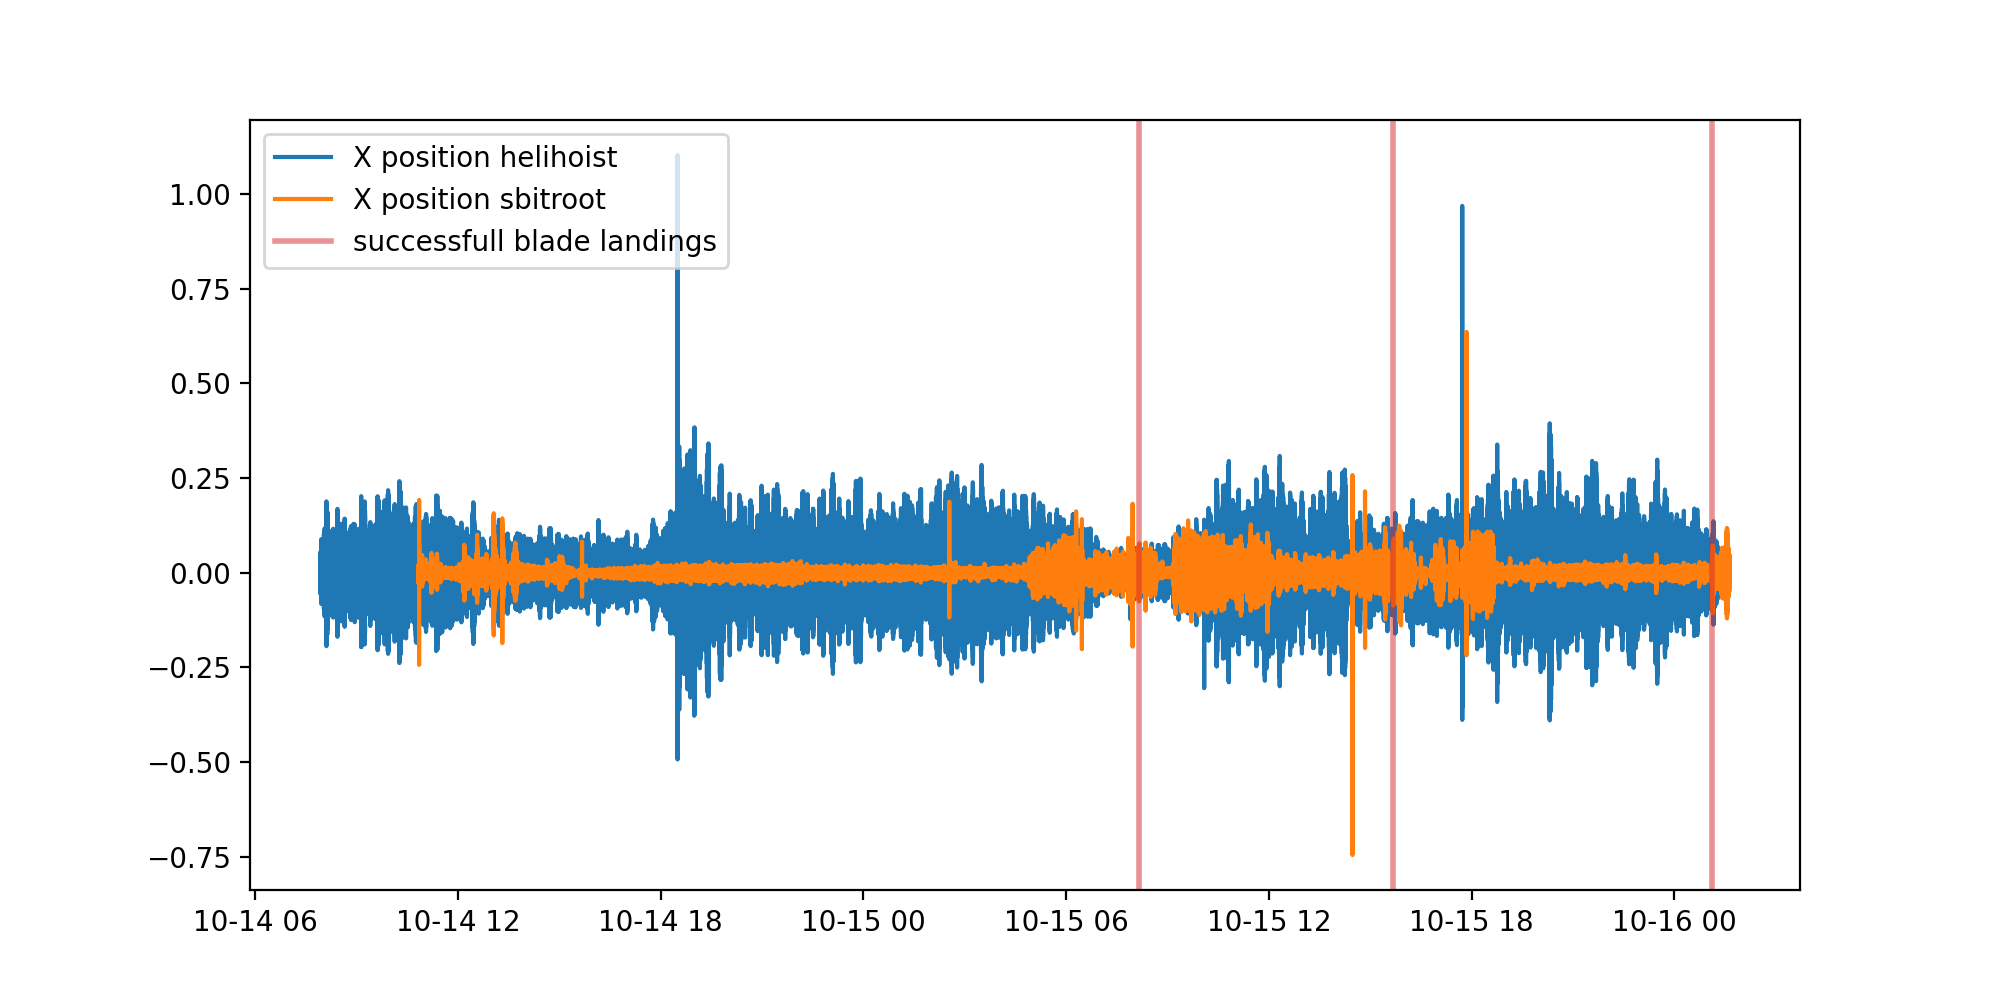

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(hh_frame.pos_x, label='X position helihoist')
plt.plot(sbitroot_frame.pos_x, label='X position sbitroot')
#plt.plot(sbittip_frame.pos_x, label='X position sbittip')

plt.axvline(x=blade_landing1, alpha=0.5, color='tab:red', linewidth=2, label='successfull blade landings')
plt.axvline(x=blade_landing2, alpha=0.5, color='tab:red', linewidth=2)
plt.axvline(x=blade_landing3, alpha=0.5, color='tab:red', linewidth=2)
plt.legend(loc='upper left')

In [14]:
start= sbitroot_frame.index[0]
end= hh_frame.index[4508014]
print(start)
print(end)

diff_hh_sbitroot= sbitroot_frame.deflection[start:end]- hh_frame.deflection[start:end]

2019-10-14 10:49:53.789999872+00:00
2019-10-16 01:16:42.972000+00:00


<IPython.core.display.Javascript object>


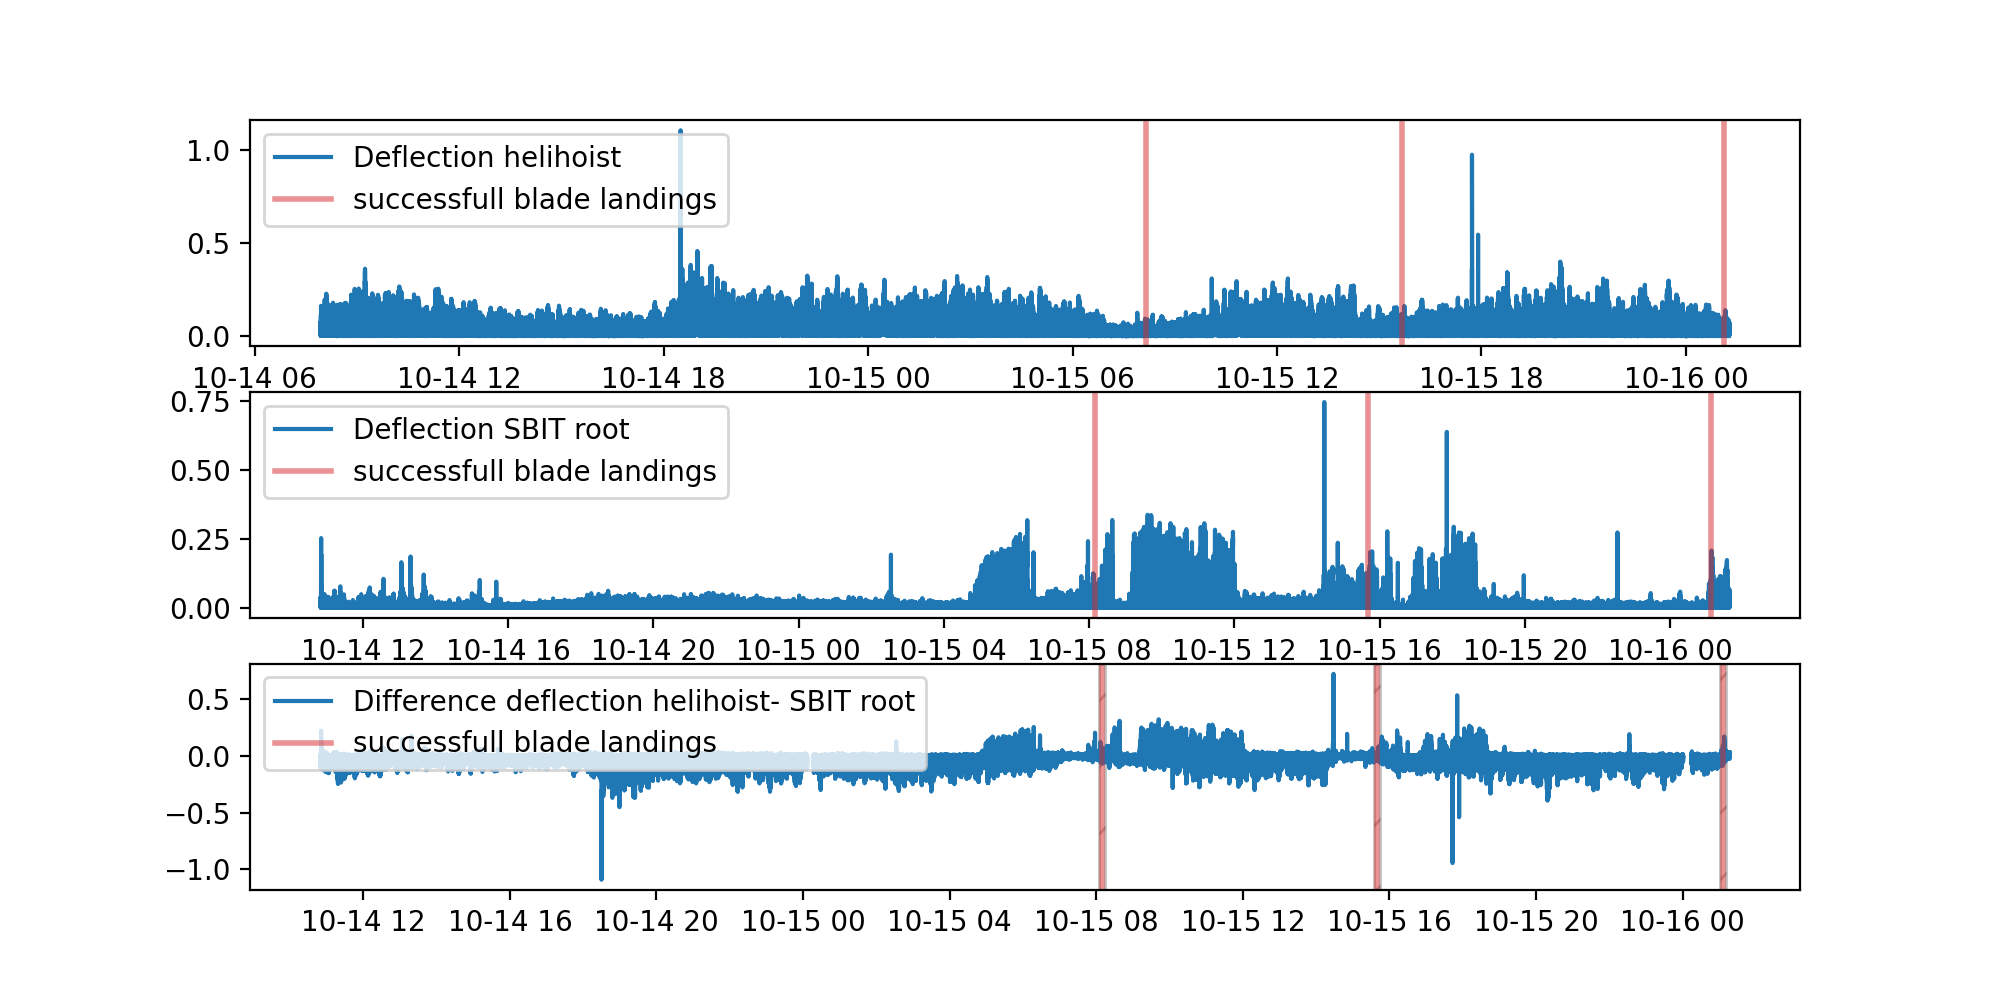

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3 , figsize=(10, 5))
ax1.plot(hh_frame.deflection, label='Deflection helihoist')
ax1.axvline(x=blade_landing1, alpha=0.5, color='tab:red', linewidth=2, label='successfull blade landings')
ax1.axvline(x=blade_landing2, alpha=0.5, color='tab:red', linewidth=2,)
ax1.axvline(x=blade_landing3, alpha=0.5, color='tab:red', linewidth=2) 
ax1.legend(loc='upper left')

ax2.plot(sbitroot_frame.deflection, label='Deflection SBIT root')
ax2.axvline(x=blade_landing1, alpha=0.5, color='tab:red', linewidth=2, label='successfull blade landings')
ax2.axvline(x=blade_landing2, alpha=0.5, color='tab:red', linewidth=2)
ax2.axvline(x=blade_landing3, alpha=0.5, color='tab:red', linewidth=2) 
ax2.legend(loc='upper left')

ax3.plot(diff_hh_sbitroot, label='Difference deflection helihoist- SBIT root')
ax3.axvline(x=blade_landing1, alpha=0.5, color='tab:red', linewidth=2, label='successfull blade landings')
ax3.axvline(x=blade_landing2, alpha=0.5, color='tab:red', linewidth=2)
ax3.axvline(x=blade_landing3, alpha=0.5, color='tab:red', linewidth=2)
ax3.axvspan(xmin=blade1_start, xmax=blade1_end, hatch='/', facecolor='white', alpha=0.25, edgecolor='k') 
ax3.axvspan(xmin=blade2_start, xmax=blade2_end, hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
ax3.axvspan(xmin=blade3_start, xmax=blade3_end, hatch='/', facecolor='white', alpha=0.25, edgecolor='k')
ax3.legend(loc='upper left')

plt.savefig('blade_landings_verification', dpi=300)

<IPython.core.display.Javascript object>


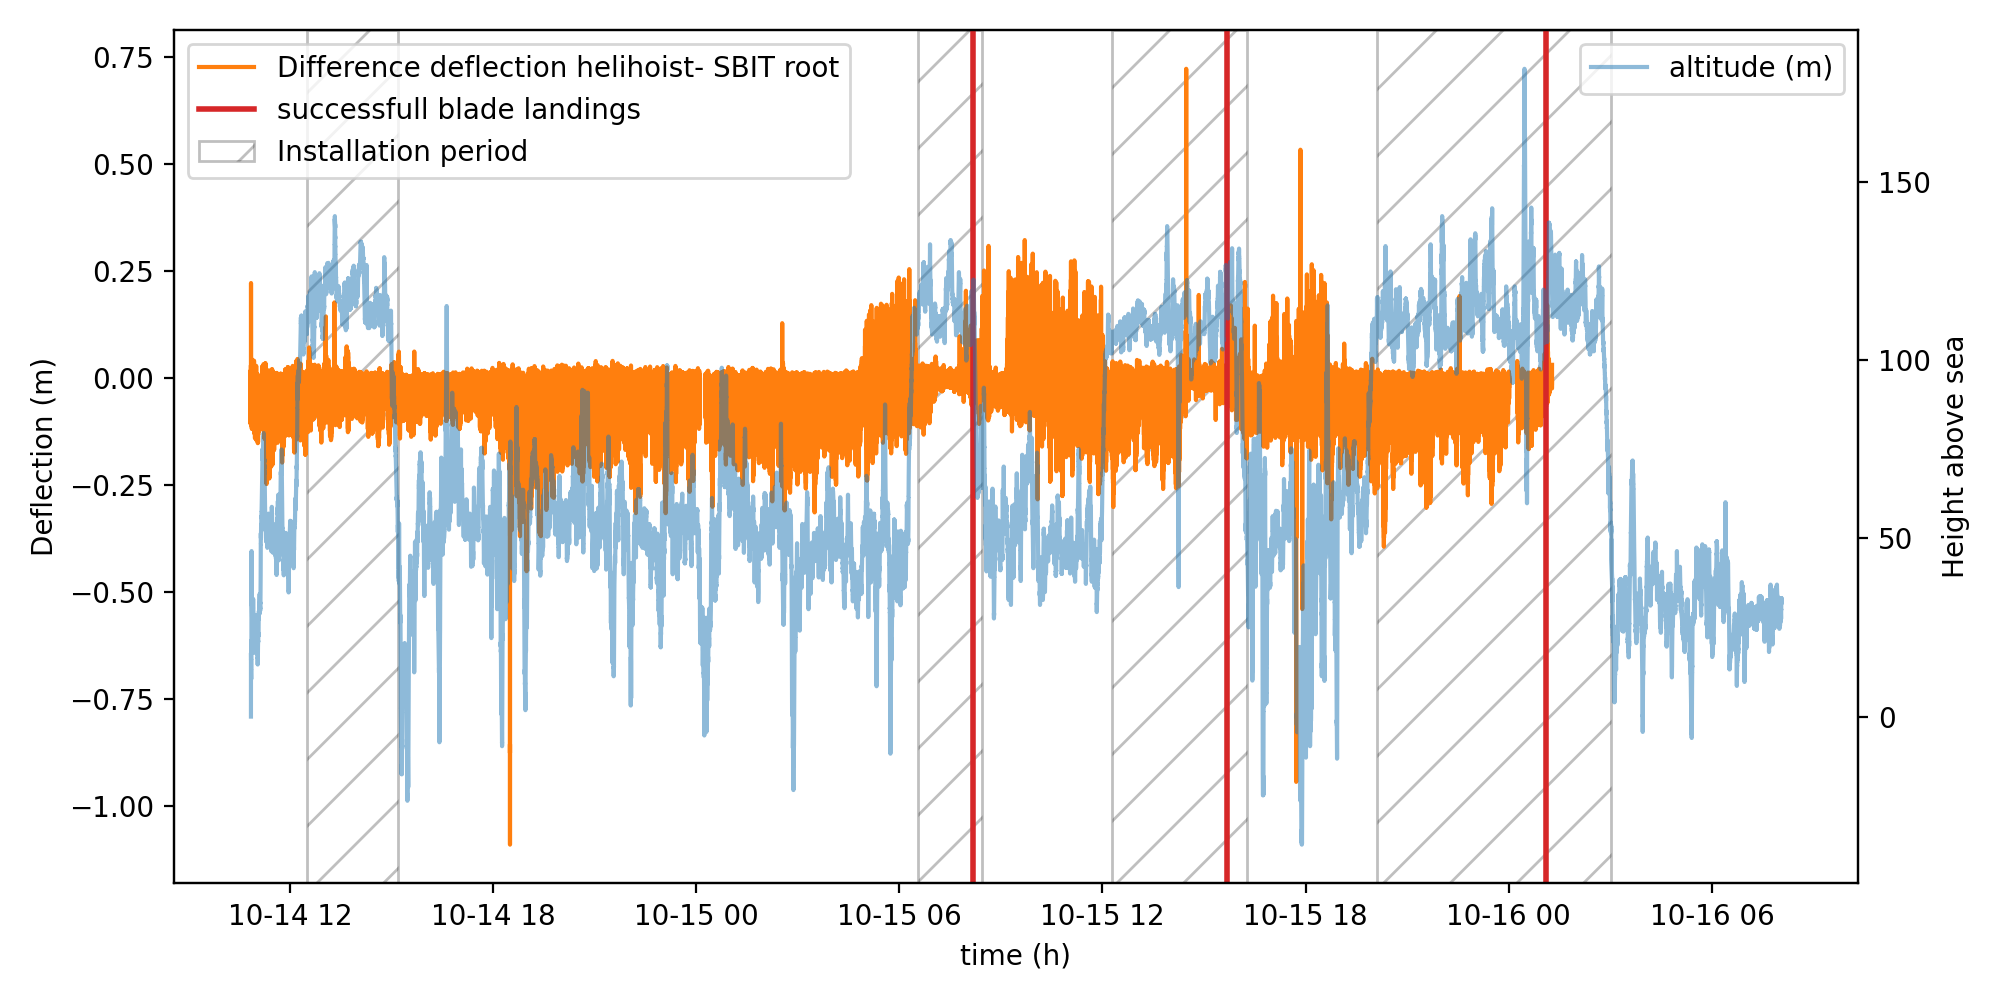

In [16]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.set_xlabel('time (h)')
ax1.set_ylabel('Deflection (m)')
ax1.tick_params(axis='y')
ax1.plot(diff_hh_sbitroot, label='Difference deflection helihoist- SBIT root', color='tab:orange')
ax1.axvline(x=blade_landing1, color='tab:red', linewidth=2, label='successfull blade landings')
ax1.axvline(x=blade_landing2, color='tab:red', linewidth=2)
ax1.axvline(x=blade_landing3, color='tab:red', linewidth=2)
ax1.axvspan(xmin=sbi_indices[0][0], xmax=sbi_indices[0][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax1.axvspan(xmin=sbi_indices[1][0], xmax=sbi_indices[1][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k', label='Installation period')   
ax1.axvspan(xmin=sbi_indices[2][0], xmax=sbi_indices[2][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax1.axvspan(xmin=sbi_indices[3][0], xmax=sbi_indices[3][1], hatch='/', facecolor='white', alpha=0.25, edgecolor='k')   
ax1.legend(loc='upper left')

ax2 = ax1.twinx()


ax2.set_ylabel('Height above sea') 
ax2.plot(gps_sbitroot_tb8.altitude, color='tab:blue', alpha= 0.5, label= 'altitude (m)')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig('blade_landings_verification', dpi=300)